In [ ]:
from pathlib import Path
import os

DAY = "20251201"
Version = "v1"

PROJECT_ROOT = Path(os.getenv("LLMSC_ROOT", ".")).resolve()

DATA_DIR = Path(os.getenv("LLMSC_DATA_DIR", PROJECT_ROOT / "input")).resolve()
OUT_DIR  = Path(os.getenv("LLMSC_OUT_DIR",  PROJECT_ROOT / "runs" / f"{DAY}.{Version}")).resolve()
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
import os
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY", "")
USE_LLM = bool(GEMINI_API_KEY)

if not USE_LLM:
    print("⚠️ GEMINI_API_KEY not set → LLM inference cells will be skipped.")

In [ ]:
import google.generativeai as genai
import scanpy as sc
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
from scipy import io
import adjustText
from adjustText import adjust_text
import gc
import os
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sklearn.metrics import confusion_matrix
from google.colab import userdata

import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s:%(name)s:%(message)s"
)

from llm_sc_curator import LLMscCurator
from llm_sc_curator.masking import FeatureDistiller

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# ==========================================
# 1. API
# ==========================================

genai.configure(api_key=GEMINI_API_KEY)
print("--- Available Models for your Key ---")
try:
    for m in genai.list_models():
        if 'generateContent' in m.supported_generation_methods:
            print(m.name)
except Exception as e:
    print(f"Error: {e}")

--- Available Models for your Key ---
models/gemini-2.5-flash
models/gemini-2.5-pro
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-exp-1206
models/gemini-2.5-flash-preview-tts
models/gemini-2.5-pro-preview-tts
models/gemma-3-1b-it
models/gemma-3-4b-it
models/gemma-3-12b-it
models/gemma-3-27b-it
models/gemma-3n-e4b-it
models/gemma-3n-e2b-it
models/gemini-flash-latest
models/gemini-flash-lite-latest
models/gemini-pro-latest
models/gemini-2.5-flash-lite
models/gemini-2.5-flash-image-preview
models/gemini-2.5-flash-image
models/gemini-2.5-flash-preview-09-2025
models/gemini-2.5-flash-lite-preview-09-2025
models/gemini-3-pro-preview
models/gemini-3-pro-image-preview
models/nano-banana-pro-preview
models/gemini-robotics-er-1.5-preview
models/gemini-2.5-computer-

In [ ]:
MODEL_NAME = 'models/gemini-2.5-pro'

# MODEL_NAME = 'models/gemini-3-pro-preview'
# MODEL_NAME = 'models/gemini-2.5-flash'
# MODEL_NAME = 'models/gemini-2.0-flash'

print(f"Using Model: {MODEL_NAME}")
model = genai.GenerativeModel(MODEL_NAME)

Using Model: models/gemini-2.5-pro


In [ ]:
# ==========================================
# 2. Load OSCC Visium Data
# ==========================================
# E-GEAD-511 (Genomic Expression Archive, GEA)
# https://ddbj.nig.ac.jp/public/ddbj_database/gea/experiment/E-GEAD-000/E-GEAD-511/
IN_FILE = DATA_DIR / "processed.h5ad"

print(f"🚀 Loading Visium Data from: {IN_FILE}")

try:
    data = sc.read_h5ad(IN_FILE)
    print(f"✅ Data Loaded: {data.n_obs} spots x {data.n_vars} genes")

except Exception as e:
    print(f"❌ Error loading data: {e}")
    # Stop execution if data load fails
    raise

data.obs["leiden"] = data.obs["leiden"].astype(int).map(lambda x: x + 1).astype(str)
data.obs["leiden"] = data.obs["leiden"].astype("str")
data.obs.replace({'leiden': {'nan':np.nan}}, inplace=True)
data = data[data.obs['category'] == "tumor"]

🚀 Loading Visium Data from: /input/processed.h5ad
✅ Data Loaded: 3637 spots x 4000 genes


In [ ]:
replacement_dict = {
    'CA_MD_to_WD': 'CA_MD_WD',
    'CA_PD': 'CA_PD',
    'CA_PD_&_fibrosis': 'CA_PD_Fib',
    'CA_PD_&_muscle': 'CA_PD_Mus',
    'CA_WD_to_MD': 'CA_WD_MD',
    'CA_fibrosis_&_lymphocyte': 'CA_Fib_Lym',
    'CA_invasive_lesion': 'CA_Inv_Les',
    'INF_&_fibrosis': 'Inf_Fib',
    'INF_&_muscle': 'Inf_Mus',
    'adipose_tissue': 'Adi_Tis',
    'blood': 'Bld',
    'conective_tissue_&_vessel': 'Con_Tis_Ves',
    'epithelium': 'Epi',
    'granuration_tissue': 'Gran_Tis',
    'lymph_node_capsle': 'LN_Cap',
    'lymphocyte': 'Lym',
    'muscle': 'Mus',
    'neuron': 'Neu',
    'neuron_in_tumor': 'Neu_Tum',
    'space': 'Space',
    'stroma': 'Stroma',
    'uncategorized': 'Uncat',
    'vessel': 'Ves'
}

data.obs['pathology'] = data.obs['pathology'].replace(replacement_dict).copy()

In [ ]:
spatial_f = DATA_DIR / 'adata_uns_spatial.pickle'
# https://doi.org/10.6084/m9.figshare.20408067

import pickle
def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

adata_uns_spatial = pickle_load(spatial_f)
adata = data[data.obs['sample']=="A"]
adata.uns["spatial"] = adata_uns_spatial

In [ ]:
adata.obs

in_tissue  array_row  array_col     imagecol  \
AAACAGCTTTCAGAAG-1-0-0          1         43          9   889.867818   
AAACAGGGTCTATATT-1-0-0          1         47         13   815.422523   
AAACCGGGTAGGTACC-1-0-0          1         42         28   908.135611   
AAACCTCATGAAGTTG-1-0-0          1         37         19  1001.333685   
AAACTTGCAAACGTAT-1-0-0          1         45         19   852.523924   
...                           ...        ...        ...          ...   
TTGTGGCCCTGACAGT-1-0-0          1         18         60  1354.079907   
TTGTGGTAGGAGGGAT-1-0-0          1         50         28   759.245019   
TTGTTAGCAAATTCGA-1-0-0          1         22         42  1279.957935   
TTGTTCAGTGTGCTAC-1-0-0          1         24         64  1242.290717   
TTGTTTCCATACAACT-1-0-0          1         45         27   852.362262   

                           imagerow  pathology category    cluster sample  \
AAACAGCTTTCAGAAG-1-0-0  1496.180699      CA_PD    tumor  cluster_6      A   
AAACAGGGTCTATATT-1-0-0  1453.501963      CA_PD    tumor  cluster_6      A   
AAACCGGGTAGGTACC-1-0-0  1292.971716  CA_PD_Fib    tumor  cluster_6      A   
AAACCTCATGAAGTTG-1-0-0  1388.998873  CA_PD_Fib    tumor  cluster_5      A   
AAACTTGCAAACGTAT-1-0-0  1389.322197  CA_PD_Fib    tumor  cluster_6      A   
...                             ...        ...      ...        ...    ...   
TTGTGGCCCTGACAGT-1-0-0   949.925207  CA_PD_Fib    tumor  cluster_5      A   
TTGTGGTAGGAGGGAT-1-0-0  1293.214209  CA_PD_Fib    tumor  cluster_2      A   
TTGTTAGCAAATTCGA-1-0-0  1142.545337  CA_PD_Mus    tumor  cluster_5      A   
TTGTTCAGTGTGCTAC-1-0-0   907.327302  CA_PD_Fib    tumor  cluster_2      A   
TTGTTTCCATACAACT-1-0-0  1303.722231  CA_PD_Fib    tumor  cluster_5      A   

                        n_counts batch  _scvi_batch  _scvi_labels leiden  \
AAACAGCTTTCAGAAG-1-0-0   46861.0     0            0             0      3   
AAACAGGGTCTATATT-1-0-0   53248.0     0            0             0      3   
AAACCGGGTAGGTACC-1-0-0   49741.0     0            0             0      3   
AAACCTCATGAAGTTG-1-0-0   39816.0     0            0             0      3   
AAACTTGCAAACGTAT-1-0-0   39005.0     0            0             0      3   
...                          ...   ...          ...           ...    ...   
TTGTGGCCCTGACAGT-1-0-0   18306.0     0            0             0      1   
TTGTGGTAGGAGGGAT-1-0-0    9972.0     0            0             0      4   
TTGTTAGCAAATTCGA-1-0-0   22596.0     0            0             0      5   
TTGTTCAGTGTGCTAC-1-0-0    9967.0     0            0             0     12   
TTGTTTCCATACAACT-1-0-0   24250.0     0            0             0      3   

                        sample_density  _scvi_raw_norm_scaling  
AAACAGCTTTCAGAAG-1-0-0        0.299178                0.488448  
AAACAGGGTCTATATT-1-0-0        0.394160                0.427991  
AAACCGGGTAGGTACC-1-0-0        0.388597                0.478057  
AAACCTCATGAAGTTG-1-0-0        0.380648                0.550964  
AAACTTGCAAACGTAT-1-0-0        0.447035                0.610352  
...                                ...                     ...  
TTGTGGCCCTGACAGT-1-0-0        0.961767                1.440300  
TTGTGGTAGGAGGGAT-1-0-0        0.132355                3.136763  
TTGTTAGCAAATTCGA-1-0-0        0.353786                1.196029  
TTGTTCAGTGTGCTAC-1-0-0        0.505471                2.930832  
TTGTTTCCATACAACT-1-0-0        0.992378                1.100231  

[983 rows x 16 columns]

In [ ]:
%%time

curator = LLMscCurator(api_key=GEMINI_API_KEY, model_name=MODEL_NAME)

visium_ctx = {
    "Assay": "10x Visium (10 cells per spot)",
    "Cancer": "Human oral squamous cell carcinoma (OSCC)",
    "Task": "Annotate Spatial Niches / OSCC states rather than cell types.",
}


import time
t0 = time.time()
adata_vis = curator.run_hierarchical_discovery(
    adata,
    global_context=visium_ctx
)
t1 = time.time()

print(f"run_hierarchical_discovery() total: {t1 - t0:.1f} sec")

adata_vis.obs["LLMsc_fine"] = adata_vis.obs["fine_type"].astype("category")

print("LLMsc_fine value counts (top 10):")
print(adata_vis.obs["LLMsc_fine"].value_counts().head(10))

run_hierarchical_discovery() total: 380.6 sec
LLMsc_fine value counts (top 10):
LLMsc_fine
Muscle-Infiltrating Carcinoma (Hypoxic, ISG-high)                    186
Tertiary Lymphoid Structure (TLS)                                    139
Myofibroblastic Carcinoma                                            129
Myofibroblastic Cancer-Associated Fibroblast                         108
Malignant Keratinocyte (Partial EMT, IFN-response, proliferating)    105
Matrix-remodeling Cancer-Associated Fibroblast (CAF) Niche            86
Malignant Keratinocyte (Partial EMT)                                  64
Basal-like carcinoma cell (ISG-high)                                  59
Basal-like carcinoma cell (EMT, proliferating)                        51
Partial EMT carcinoma cell (Hypoxic)                                  30
Name: count, dtype: int64
CPU times: user 44.4 s, sys: 2.32 s, total: 46.7 s
Wall time: 6min 20s


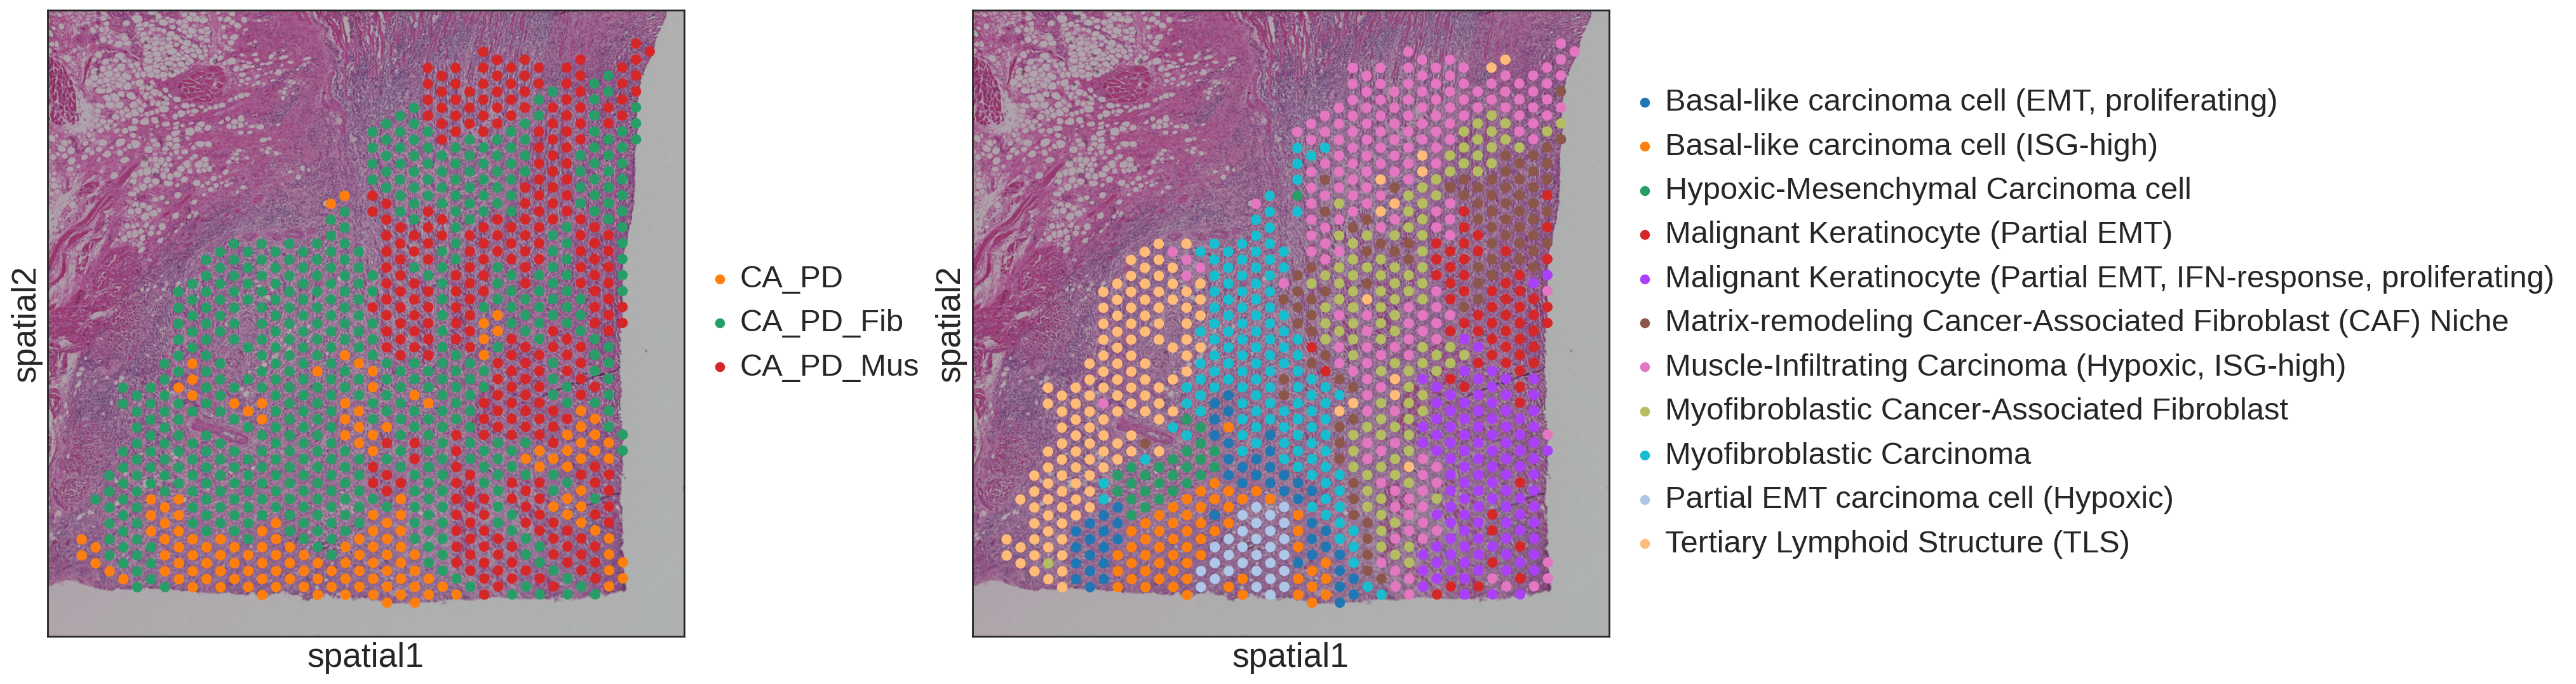

In [ ]:
sc.set_figure_params(facecolor="white", figsize=(10, 8), dpi_save=300, fontsize=20)
sns.set(font_scale=2, style='white')
plt.rcParams['font.family'] = 'Liberation Sans'

sc.pl.spatial(adata=adata,
              color=['pathology', "LLMsc_fine"],
              na_in_legend=False,
              title=["", ""],
              save=f".{DAY}_adada.region_spatialplot.{Version}.pdf"
              )

In [ ]:
adata_vis.obs["LLMsc_fine"].value_counts()

LLMsc_fine
Muscle-Infiltrating Carcinoma (Hypoxic, ISG-high)                    186
Tertiary Lymphoid Structure (TLS)                                    139
Myofibroblastic Carcinoma                                            129
Myofibroblastic Cancer-Associated Fibroblast                         108
Malignant Keratinocyte (Partial EMT, IFN-response, proliferating)    105
Matrix-remodeling Cancer-Associated Fibroblast (CAF) Niche            86
Malignant Keratinocyte (Partial EMT)                                  64
Basal-like carcinoma cell (ISG-high)                                  59
Basal-like carcinoma cell (EMT, proliferating)                        51
Partial EMT carcinoma cell (Hypoxic)                                  30
Hypoxic-Mesenchymal Carcinoma cell                                    26
Name: count, dtype: int64

In [ ]:
# ==========================================
# 1. Standardize label wording
# ==========================================

label_map = {
    # --- Tumor / Malignant ---
    "Muscle-Infiltrating Carcinoma (Hypoxic, ISG-high)": "Tumor (Invasive/Hypoxic)",
    "Myofibroblastic Carcinoma":                         "Tumor (Myofibroblastic/EMT)",
    "Malignant Keratinocyte (Partial EMT, IFN-response, proliferating)": "Tumor (p-EMT/proliferating/ISG)",
    "Malignant Keratinocyte (Partial EMT)":              "Tumor (p-EMT)",
    "Basal-like carcinoma cell (ISG-high)":              "Tumor (Basal/ISG)",
    "Basal-like carcinoma cell (EMT, proliferating)":    "Tumor (Basal/proliferating)",
    "Partial EMT carcinoma cell (Hypoxic)":              "Tumor (p-EMT/Hypoxic)",
    "Hypoxic-Mesenchymal Carcinoma cell":                "Tumor (Mesenchymal/Hypoxic)",

    # --- Stromal / CAF  ---
    "Myofibroblastic Cancer-Associated Fibroblast":      "CAF (Myofibroblastic)", # or myCAF
    "Matrix-remodeling Cancer-Associated Fibroblast (CAF) Niche": "CAF (Matrix-remodeling)", # or mCAF

    # --- Structures ---
    "Tertiary Lymphoid Structure (TLS)":                 "TLS (Tertiary Lymphoid Structure)"
}


In [ ]:
def harmonize_labels(adata, col="fine_type", mapping=None, new_col=None):
    """
    Apply a user-provided mapping dict to harmonize LLM labels.

    This is intentionally a thin wrapper: all ontology decisions are
    encoded explicitly in `mapping` and stay outside the core engine.
    """
    if mapping is None:
        return adata

    if new_col is None:
        new_col = f"{col}_harmonized"

    adata.obs[f"{col}_raw"] = adata.obs[col].astype("string")
    adata.obs[new_col] = adata.obs[col].replace(mapping).astype("category")
    return adata


In [ ]:
fine_col = "LLM_fine_label"

adata_vis = harmonize_labels(
    adata_vis,
    col="LLMsc_fine",
    mapping=label_map,
    new_col=fine_col
)

fine_order = [
    # --- Tumor / Malignant  ---
    "Tumor (p-EMT/Hypoxic)",
    "Tumor (Basal/ISG)",
    "Tumor (Basal/proliferating)",
    "Tumor (Mesenchymal/Hypoxic)",
    "Tumor (Invasive/Hypoxic)",
    "Tumor (Myofibroblastic/EMT)",
    "Tumor (p-EMT/proliferating/ISG)",
    "Tumor (p-EMT)",

    # --- Stromal / CAF  ---
    "CAF (Myofibroblastic)", # or myCAF
    "CAF (Matrix-remodeling)", # or mCAF

    # --- Structures ---
    "TLS (Tertiary Lymphoid Structure)"
]

present = [c for c in fine_order if c in adata_vis.obs[fine_col].cat.categories]
adata_vis.obs[fine_col] = pd.Categorical(
    adata_vis.obs[fine_col],
    categories=present,
    ordered=True,
)

print(adata_vis.obs[fine_col].value_counts())

LLM_fine_label
Tumor (Invasive/Hypoxic)             186
TLS (Tertiary Lymphoid Structure)    139
Tumor (Myofibroblastic/EMT)          129
CAF (Myofibroblastic)                108
Tumor (p-EMT/proliferating/ISG)      105
CAF (Matrix-remodeling)               86
Tumor (p-EMT)                         64
Tumor (Basal/ISG)                     59
Tumor (Basal/proliferating)           51
Tumor (p-EMT/Hypoxic)                 30
Tumor (Mesenchymal/Hypoxic)           26
Name: count, dtype: int64


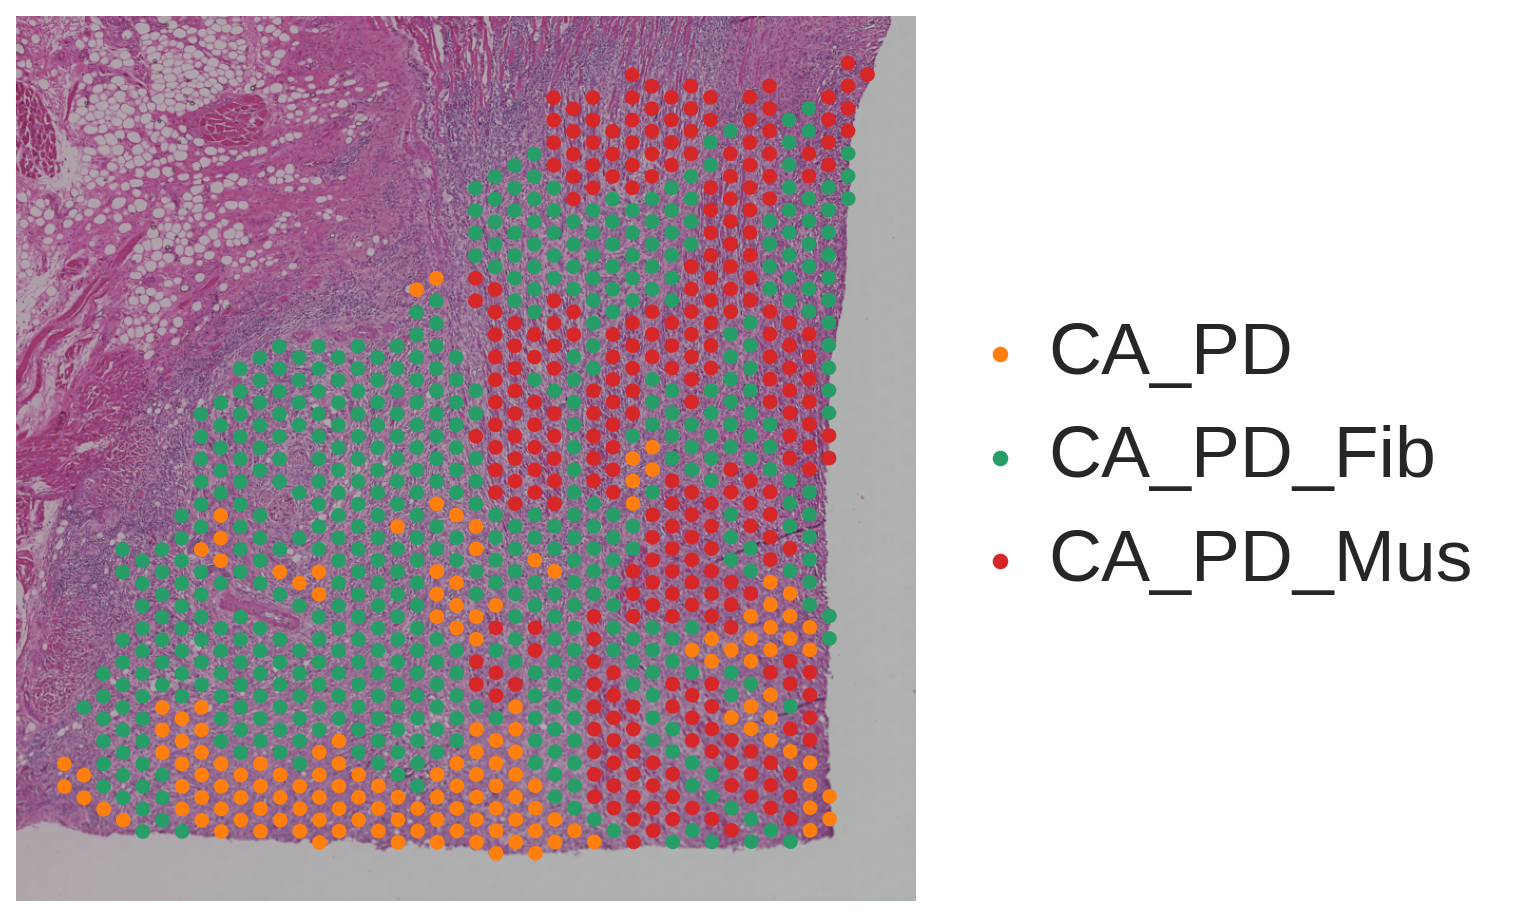

In [ ]:
sc.set_figure_params(facecolor="white", figsize=(7.21, 10), dpi_save=300, fontsize=12)
sns.set(font_scale=3, style='white')
plt.rcParams['font.family'] = 'Liberation Sans'

sc.pl.spatial(
    adata=adata_vis,
    color=['pathology'],
    na_in_legend=False,
    title=[""],
    frameon=False,
    wspace=0.0,
    hspace=0.1,
    save=f"show.EDFig3a_adada.region_spatialplot.pdf"
)

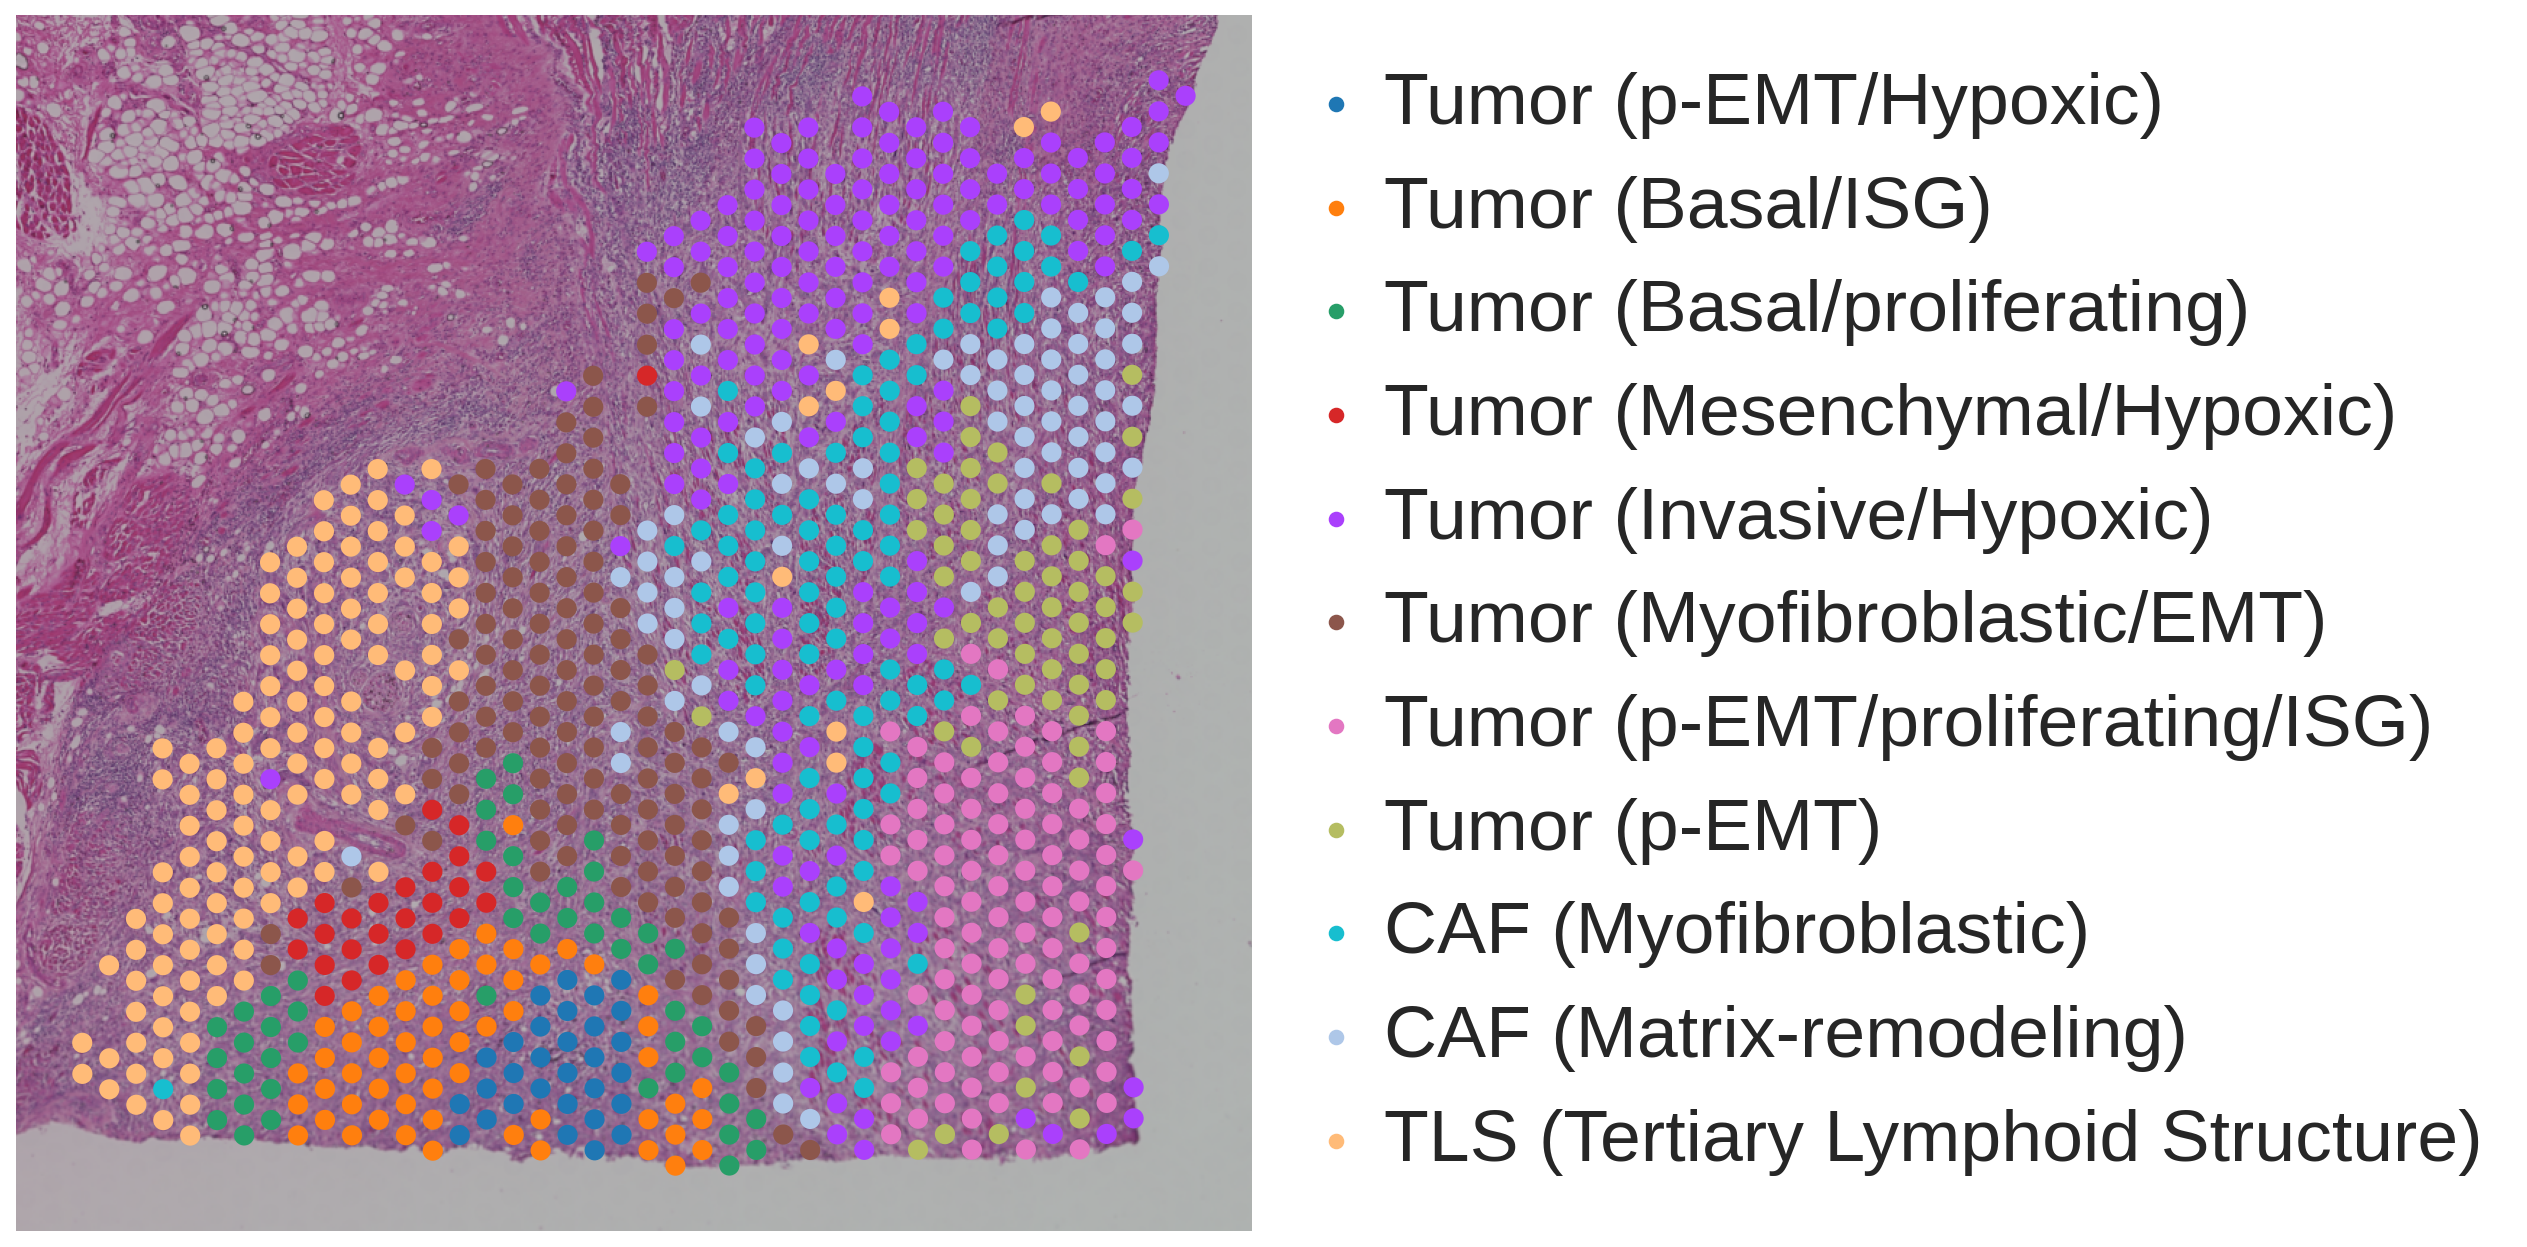

In [ ]:
sc.pl.spatial(
    adata=adata_vis,
    color=["LLM_fine_label"],
    na_in_legend=False,
    title=[""],
    frameon=False,
    wspace=0.0,
    hspace=0.1,
    save=f".EDFig3b_adada.region_spatialplot.pdf"
)

In [ ]:
anno_df = adata_vis.obs["LLM_fine_label"].copy()
anno_df.index.name = "cell_id"
csv_path = os.path.join(OUT_DIR, "visium_llmsc_finetype.csv")
anno_df.to_csv(csv_path)

print("LLM-scCurator annotation written to:")
print(csv_path)

LLM-scCurator annotation written to:
/runs/20251201.v1/visium_llmsc_finetype.csv


In [ ]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
# ==========================================
# 1. Definition of Marker Gene List (for OSCC / Visium)
# ==========================================
oscc_markers = [
    # --- Epithelial / Basal ---
    "KRT5", "KRT14", "TP63", "EPCAM",
    # --- Proliferation ---
    "MKI67", "TOP2A",
    # --- Interferon / ISG ---
    "ISG15", "IFIT1", "MX1", "STAT1",
    # --- Hypoxia ---
    "HIF1A", "VEGFA", "CA9", "SLC2A1",
    # --- Partial EMT ---
    "LAMC2", "TNC", "PDPN", "ITGA5",
    # --- Mesenchymal / Myofibroblastic ---
    "VIM", "FN1", "MMP9", "ACTA2", "COL1A1", "TAGLN",
    # Immune / TLS
    "CD3D", "MS4A1", "PTPRC"
]

# Focus only on genes present in the dataset.
valid_markers = [g for g in oscc_markers if g in adata_vis.var_names]

# ==========================================
# 2. Calculation of Pseudo-bulk (Average Expression Level per Class)
# ==========================================
print("📊 Calculating pseudo-bulk expression for heatmap...")


subset_df = pd.DataFrame(
    adata_vis[:, valid_markers].X.toarray() if scipy.sparse.issparse(adata_vis.X) else adata_vis[:, valid_markers].X,
    index=adata_vis.obs_names,
    columns=valid_markers
)

# Add LLM label
subset_df["LLM_Label"] = adata_vis.obs["LLM_fine_label"].values

# # Group by Mean for each label
pseudobulk_df = subset_df.groupby("LLM_Label").mean().T

# ==========================================
# 3. Save as CSV (to be read in R)
# ==========================================
csv_path_matrix = os.path.join(outdir, "visium_heatmap_matrix.csv")
pseudobulk_df.to_csv(csv_path_matrix)

print(f"✅ Heatmap matrix saved to: {csv_path_matrix}")
print("   (Now use the R script to plot this CSV)")

📊 Calculating pseudo-bulk expression for heatmap...
✅ Heatmap matrix saved to: /runs/20251201.v1/visium_heatmap_matrix.csv
   (Now use the R script to plot this CSV)


Heatmap saved to: /runs/20251201.v1/EDFig3d_Visium_OSCC_Heatmap_Simple.pdf 


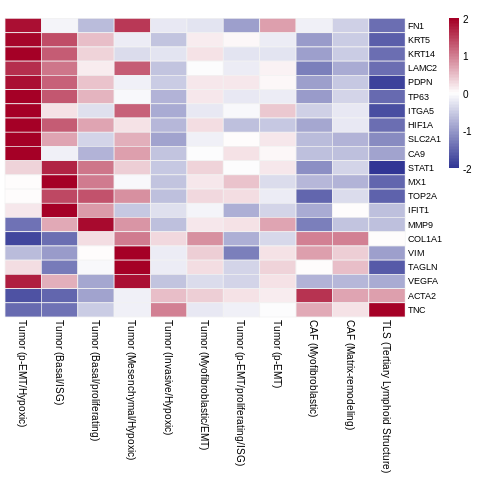

In [ ]:
%%R
library(pheatmap)

# ============================
# 1. Load the matrix created in Python
# ============================
matrix_path <- "/runs/20251201.v1/visium_heatmap_matrix.csv"

mat <- read.csv(matrix_path, row.names = 1, check.names = FALSE)
mat <- as.matrix(mat)

# ============================
# 2. Sorting and Merging Classes (Columns)
# ============================

# --- A. Check the current column name ---
current_cols <- colnames(mat)
# cat("Current columns:\n"); print(current_cols)

# --- B. Unification Mapping (Resolving Variations in Notation) ---
target_order <- c(
    # --- Tumor / Malignant (統一: Tumor) ---
    "Tumor (p-EMT/Hypoxic)",
    "Tumor (Basal/ISG)",
    "Tumor (Basal/proliferating)",
    "Tumor (Mesenchymal/Hypoxic)",
    "Tumor (Invasive/Hypoxic)",
    "Tumor (Myofibroblastic/EMT)",
    "Tumor (p-EMT/proliferating/ISG)",
    "Tumor (p-EMT)",

    # --- Stromal / CAF (統一: CAF) ---
    "CAF (Myofibroblastic)", # or myCAF
    "CAF (Matrix-remodeling)", # or mCAF

    # --- Structures ---
    "TLS (Tertiary Lymphoid Structure)"
)

final_order <- intersect(target_order, colnames(mat))
mat_sorted <- mat[, final_order]

# ============================
# 3. Gene (Row) Sorting (Diagonal Sort)
# ============================
peak_class_idx <- apply(mat_sorted, 1, which.max)
peak_val <- apply(mat_sorted, 1, max)
ord <- order(peak_class_idx, -peak_val)

mat_final <- mat_sorted[ord, ]

# ============================
# 4. Drawing
# ============================
out_pdf <- file.path(dirname(matrix_path), "EDFig3d_Visium_OSCC_Heatmap_Simple.pdf")


p <- pheatmap(
  mat_final,
  scale = "row",           # Standardized each row (Z-score)
  cluster_rows = FALSE,    # Follow the order
  cluster_cols = FALSE,    # Follow the order
  color = colorRampPalette(c("#313695", "white", "#a50026"))(100),
  breaks = seq(-2, 2, length.out = 101),

  fontsize_row = 9,
  fontsize_col = 10,
  border_color = "grey95",
  main = ""
)

pdf(out_pdf, width = 4, height = 7)
print(p )
dev.off()

cat("Heatmap saved to:", out_pdf, "\n")